# Set-ups

In [6]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
# Import KNNImputer from sklearn
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings



# User Defined Helper Functions

Below are three helper functions we will be using in this workshop. You can create your own if you think it is necessary OR directly use already available helper functions within `sklearn library`.  

- `tidy_scores()`: Simple function for getting the summary of cross-validation results in a tidy way.
- `pretty_confusion_matrix()`: Returns the confusion matrix in a nicer way but works for only binary classification!
- `plot_roc_curve()` : ROC curve plotting function based on a given threshold

You can modify the following functions based on your needs as well. These practices would be important while you are working on your project either. 

In [7]:
# tidy the output into a dataframe
# We will use for getting the summary of cross-validation results in some parts
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

In [8]:
# this creates the matplotlib graph to make the confmat look nicer
# WARNING 1: IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !!!
# WARNING 2: The locations of TP, FP, TN, and FN are varying when you compared with our notes !!!

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [9]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# EDA and Feature Engineering

In [10]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()
# plot_col = ['default','fico']
# sns.pairplot(d[plot_col])

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0



1. **缺失值处理：** 用KNN或其他方法填补缺失值是很重要的，因为许多机器学习算法不能处理缺失值。


In [11]:
# Display the number of missing values for each column
missing_values = d.isnull().sum()
missing_values_non_zero = missing_values[missing_values > 0]
print("Missing values in each column (excluding zeros):\n", missing_values_non_zero)

# Imputation with KNN
imputer = KNNImputer(n_neighbors=5)
d_imputed = pd.DataFrame(imputer.fit_transform(d.select_dtypes(include='number')), columns=d.select_dtypes(include='number').columns)
# 将非数值型数据的列添加回d_imputed中
non_numeric_columns = d.select_dtypes(exclude='number').columns
d_imputed[non_numeric_columns] = d[non_numeric_columns]

# 现在d_imputed应该包含所有原始的变量了
missing_values_after_imputation = d_imputed.isnull().sum()
print("Missing values in each column after imputation with KNN :\n ", missing_values_after_imputation)


Missing values in each column (excluding zeros):
 fico             1
cd_msa         594
ppmt_pnlty      38
flag_sc       5751
dtype: int64
Missing values in each column after imputation with KNN :
  fico                 0
dt_first_pi          0
dt_matr              0
cd_msa               0
mi_pct               0
cnt_units            0
cltv                 0
dti                  0
orig_upb             0
ltv                  0
int_rt               0
zipcode              0
orig_loan_term       0
cnt_borr             0
prepaid              0
default              0
flag_fthb            0
occpy_sts            0
channel              0
ppmt_pnlty          38
prod_type            0
st                   0
prop_type            0
id_loan              0
loan_purpose         0
seller_name          0
servicer_name        0
flag_sc           5751
dtype: int64



2. **时间特征转换：** `dt.first_pi`（首次付款日期）和`dt.matr`（到期日期）可以转换成一个数值特征，表示贷款期限的长度。我们可以简单地计算这两个日期之间的月份差来代表这个时间段。这个数值将是一个有用的特征，因为更长的贷款期限可能与不同的违约风险相关。


In [12]:
# Convert dt_first_pi and dt_matr to datetime
d_imputed['dt_first_pi'] = pd.to_datetime(d_imputed['dt_first_pi'], format='%Y%m')
d_imputed['dt_matr'] = pd.to_datetime(d_imputed['dt_matr'], format='%Y%m')

# Calculate the loan term in months
d_imputed['loan_term_months'] = (d_imputed['dt_matr'].dt.year - d_imputed['dt_first_pi'].dt.year) * 12 + \
                         (d_imputed['dt_matr'].dt.month - d_imputed['dt_first_pi'].dt.month)
# print(d_imputed['loan_term_months'])


3.  **删去不可用值：**
- **cltv - 初始组合贷款至价值比（CLTV）：** 如果为999则表示“不可用”。这个比率是指抵押贷款的原始金额与抵押财产价值的组合比率。
- **dti - 原始债务收入比（DTI）：** 披露债务收入比，即借款人每月负债总额与总月收入的比率。如果这个比率超过65%，则该数据被标记为“不可用”（999）。


In [13]:
# Remove rows where 'cltv' is 999
removal_terms = (d_imputed['cltv'] != 999) & (d_imputed['dti'] != 999) & (d_imputed['ltv'] != 999)

d_imputed_cleaned = d_imputed[removal_terms]

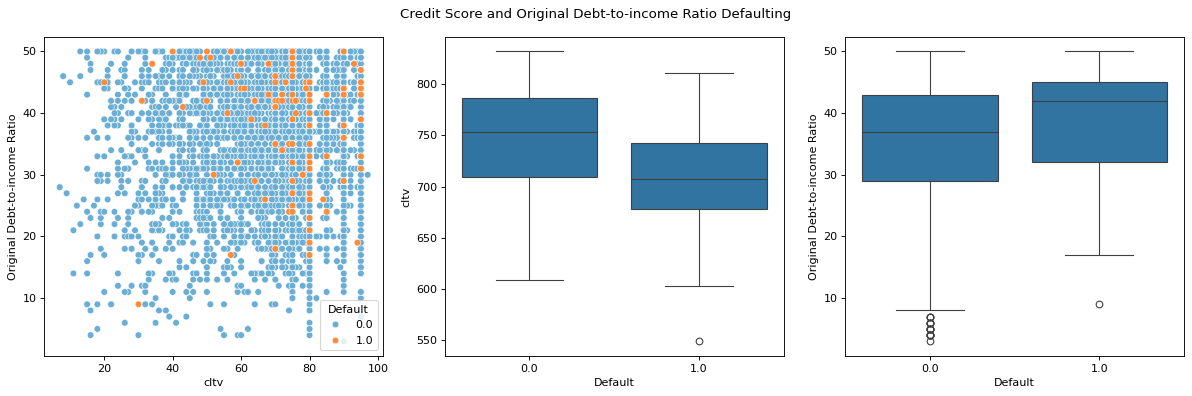

In [14]:
# How variables are related to each other 

# fico_label = "Credit Score"
cltv_label = "cltv"
dti_label = "Original Debt-to-income Ratio"
default_label = "Default"

fig, axes = plt.subplots(ncols = 3, figsize=(15,5))

# Main scatterplots and boxplots for each feature in terms of response 
sns.scatterplot(data = d_imputed_cleaned[d_imputed_cleaned['default']== 0], x = "cltv", y="dti", hue="default", palette='Blues',ax=axes[0])
sns.scatterplot(data = d_imputed_cleaned[d_imputed_cleaned['default']== 1], x = "cltv", y="dti",hue="default", palette='Oranges',ax=axes[0])
sns.boxplot(data = d_imputed_cleaned, x = "default", y="fico", ax=axes[1])
sns.boxplot(data = d_imputed_cleaned, x = "default", y="dti", ax=axes[2])

axes[0].legend(title=default_label)
axes[0].set_xlabel(cltv_label)
axes[0].set_ylabel(dti_label)
axes[1].set_xlabel(default_label)
axes[1].set_ylabel(cltv_label)
axes[2].set_xlabel(default_label)
axes[2].set_ylabel(dti_label)

plt.suptitle("Credit Score and Original Debt-to-income Ratio Defaulting")
plt.tight_layout()
plt.show()

删除变量：
`flag_fthb` - 首次购房者标志，通常是有限的分类（如是/否/9）。
删除原因：6104条贷款数据中有3468个不可用值，这意味着至少有50%的数据是缺失的。

经分析，该变量不是预测模型中的关键因素，我们相信该变量与目标变量之间没有显著关联，我们选择从分析中删除该变量。

`cd_msa`,`zipcode`- 大都市统计区域（MSA）代码：** 用于指明抵押财产所在的大都市统计区域或大都市区的代码，如果为空，则表示该地区既不是一个MSA也不是一个大都市区，或者未知。
删除原因：The values of variable country do not have numerical meaning, and instead it is an objective classfication. Hence it is critical to use OneHotEncoding to transform this feature. 但这样做会使变量过多，数据臃肿，同时此数据集中有用以确定房产位置的变量`st`。因此考虑删除。

`id.loan` - 贷款唯一标识符：对分析没有用

`prepaid ` - 是否提前支付: 与 `default` 有100%负关联性，不做考虑。

`ppmt-pnlty` -- 提前还款罚金贷款（PPM）标志：** 表示抵押贷款是否是PPM。PPM是指借款人在某些还本事件中被要求支付罚金的抵押贷款。
删除原因：数据没有Y，只有N和空白，对分析没有参考意义。






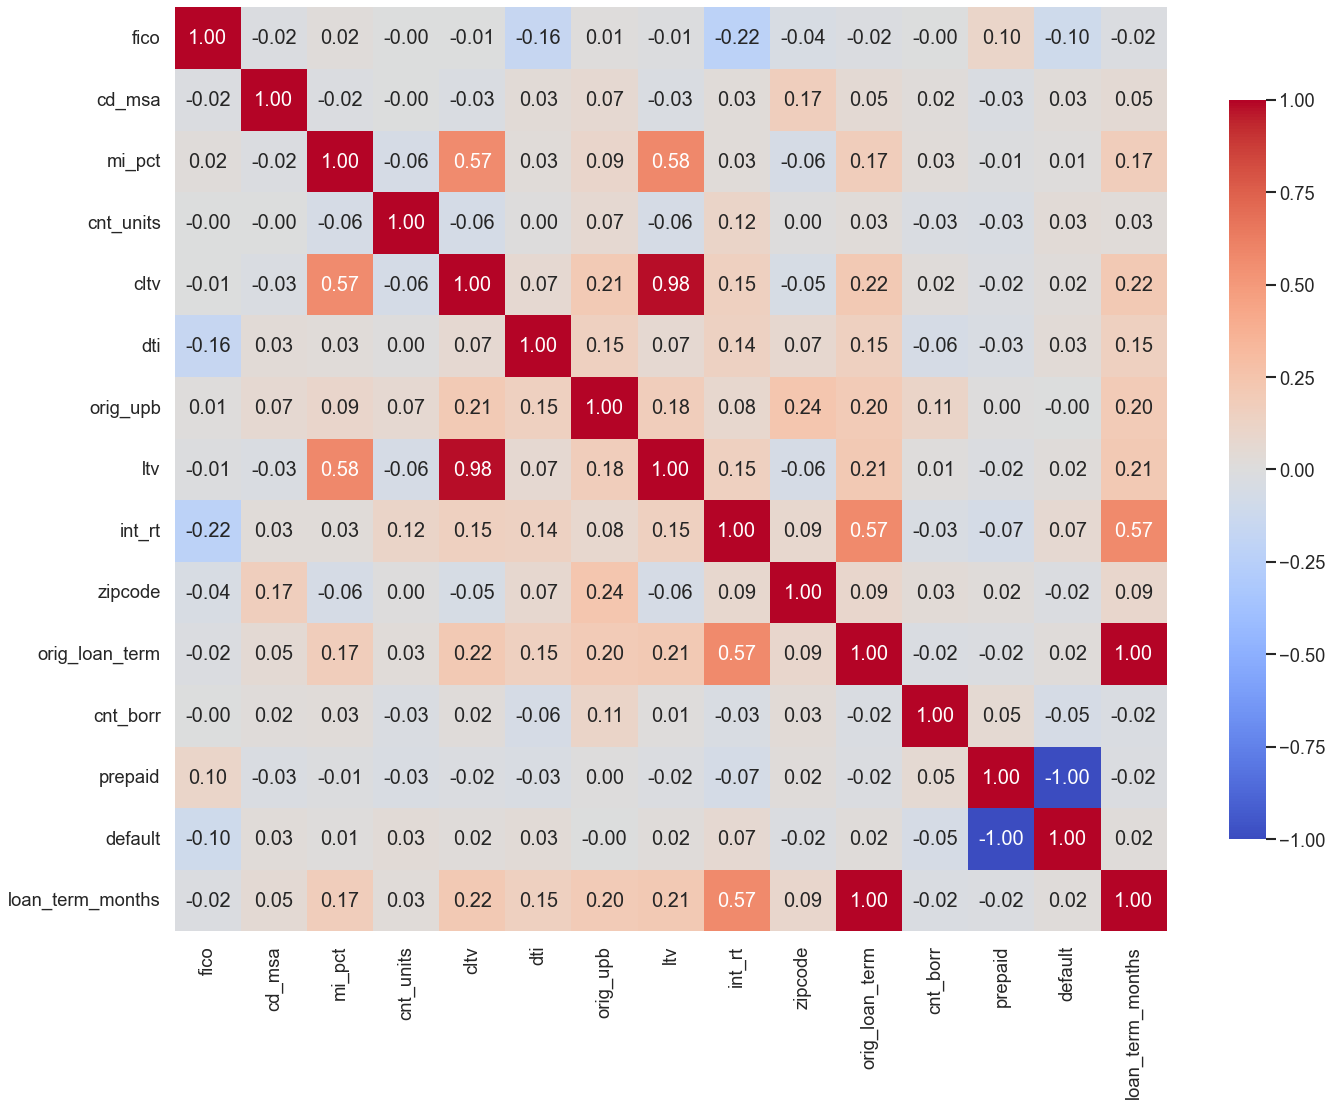

In [15]:
# # Plotting the data set
# sns.pairplot(data = d, hue = "default")
# 只选取数值型数据来计算相关性矩阵
numeric_data = d_imputed_cleaned.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
# 设置绘图风格和字体大小
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1)


# 创建一个更大的画布
plt.figure(figsize=(20, 15))

# 绘制热图并调整颜色条的高度
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})

# 显示图形
plt.show()




从热图中，我们可以看到：

1. `cltv`和`ltc`具有极强的关联性(0.98)，他们的具体意义也相近，因此我们留`cltv`删除`ltv`.
2. `orig_loan_term`与我们计算出的`loan_term_months`的关联度为1，因此我们删除计算出的`loan_term_months`指标。
3. 值得注意的是，`cltv`与`mi_pct`指标具有相对较高的关联度(0.58);`int_rt`与`orig_loan_term`具有相对较高的关联度(0.57),这表明贷款在发起时票据上注明的利率与抵押贷款的预定月付款次数有内在联系。

In [16]:
# 综上，我们进行变量重整
# To remove the 'flag_fthb' column from your DataFrame
drop_list = ['flag_fthb','cd_msa','zipcode','prepaid','ppmt_pnlty','ltv','loan_term_months','dt_first_pi','dt_matr','id_loan']
d_imputed_cleaned_dropped = d_imputed_cleaned.drop(drop_list, axis=1)

In [17]:
matches = d_imputed_cleaned_dropped.apply(lambda row: row['seller_name'] == row['servicer_name'], axis=1)
match_rate = matches.mean()
print(f"The match rate between the two columns is: {match_rate:.2%}")


The match rate between the two columns is: 45.15%


因此我们选择保留这两列。

4.**数据观察**

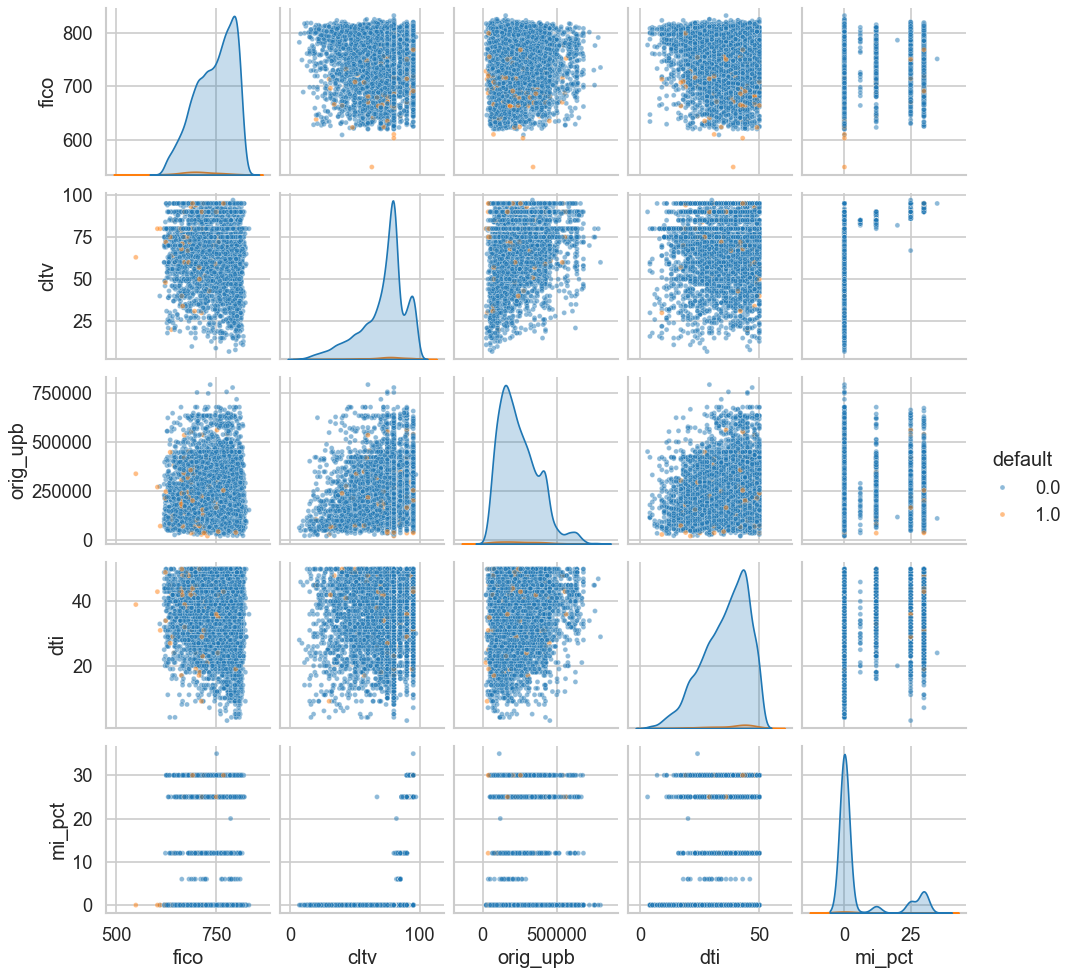

In [18]:
# 调整透明度和点的大小
sns.pairplot(data=d_imputed_cleaned_dropped[['fico', 'cltv','orig_upb','dti','mi_pct', 'default',]], hue="default", plot_kws={'alpha':0.5, 's':20})


plt.show()


5. **分类变量编码：** 如`flag_fthb`（首次购房者标志），`channel`（贷款渠道）和`prop_type`（物业类型）等下列分类变量应进行独热编码，这样才能在大多数机器学习模型中使用。

    1. `channel` - 贷款渠道，可能有几个固定类别，如零售、经纪人或通讯录。
    2. `occupy_sts` - 占用状态，指明房产是自住、第二住宅还是投资物业。
    3. `prod_type` - 产品类型，例如固定利率抵押或可调利率抵押。
    4. `prop_type` - 物业类型，如公寓、规划单元开发、合作社份额、移动家居或单户家庭。
    5. `loan_purpose` - 贷款用途，指明是购买、再融资或现金外再融资。
    6. `flag_sc` - 超级合规标志： 对于2008年10月1日或之后发起并交付给房利美的超出合规贷款限额的抵押贷款。
分类变量通常需要经过适当的处理，如编码，才能用于统计分析和机器学习模型。对于二分类变量，可以使用标签编码（0和1）。对于多分类变量，通常使用独热编码（One-Hot Encoding），以创建多个二进制（0或1）特征，每个特征对应一个类别，从而避免引入不必要的数值关联。


In [19]:
# Assuming a DataFrame 'df' from the dataset you provided, we will apply One-Hot Encoding to categorical variables.

# First, let's define which columns are categorical based on the provided variable descriptions.
categorical_columns = ['channel', 'occpy_sts', 'prod_type', 'prop_type', 'loan_purpose','flag_sc']
# categorical_columns = ['channel']
# Apply One-Hot Encoding to categorical columns
d_imputed_cleaned_dropped_onehot = pd.get_dummies(d_imputed_cleaned_dropped, columns=categorical_columns)



6. **目标编码（Target Encoding）：** 当处理类别型变量如州名缩写`st`时，面临着一个挑战，特别是如果类别数量较多，直接应用独热编码可能导致特征维度急剧增加，这可能会引起维度灾难，增加模型训练的难度和过拟合的风险。因此我们使用目标编码方式对类别数量过多的变量进行处理，目标编码是根据每个类别对应目标变量的平均值来编码的。例如，你可以将每个州编码为其房产违约率的平均值。这种方法可以提供有关目标变量的直接信息，但需要小心处理，以避免数据泄露：确保在交叉验证的每次迭代中，目标编码都是仅使用训练数据计算得出的。
    
    1. `servicer_name` - 服务机构名称，如果数据集中这是一组预定义的服务机构名称，则它是分类的。
    2. `seller_name` - 卖方名称，同服务机构名称，如果是预定义的名称列表则为分类变量。
    3. `st` - 州名缩写，代表房产所在州，这是一个固定的分类列表。The values of variable country do not have numerical meaning, and instead it is an objective classfication. Hence it is critical to use OneHotEncoding to transform this feature.

为了确保目标编码仅使用训练数据计算得出，我们可以创建一个函数，这个函数将接受原始数据集、需要进行目标编码的列名列表、目标变量列名，以及分割训练和测试数据的索引。这样可以确保目标编码器仅在每次训练时使用相应的训练数据进行拟合。

下面是如何实现这个功能的示例代码：

In [20]:
def target_encode_columns(train_data, test_data, columns_to_encode = ['servicer_name', 'seller_name', 'st'], target_column = 'default'):
    """
    对指定的列进行目标编码，确保编码仅使用训练数据。
    
    参数:
    - train_data: 训练数据集的DataFrame
    - test_data: 测试数据集的DataFrame
    - columns_to_encode: 需要进行目标编码的列名列表
    - target_column: 目标变量的列名
    
    返回:
    - train_encoded: 编码后的训练数据集
    - test_encoded: 编码后的测试数据集
    """
    # 创建目标编码器实例
    encoder = TargetEncoder()
    
    # 深拷贝训练和测试数据集，避免修改原始DataFrame
    train_encoded = train_data.copy()
    test_encoded = test_data.copy()
    
    # 对每个指定列进行目标编码
    for column in columns_to_encode:
        # 使用训练数据拟合编码器
        encoder.fit(train_encoded[column], train_encoded[target_column])
        
        # 对训练和测试数据集的列进行转换
        train_encoded[column] = encoder.transform(train_encoded[column])
        test_encoded[column] = encoder.transform(test_encoded[column])
    
    return train_encoded, test_encoded

# Model Fitting and Tuning

# 数据处理：

In [21]:

X = d_imputed_cleaned_dropped_onehot.drop('default', axis=1)
y = d_imputed_cleaned_dropped_onehot['default']
print(X.shape)
print(y.shape)

# Before Splitting the data set 
print("Class Distribution (%)")
# get our null accuracy rate 
print(y.value_counts(normalize=True)*100)


(6102, 28)
(6102,)
Class Distribution (%)
default
0.0    98.148148
1.0     1.851852
Name: proportion, dtype: float64


在`train_test_split`函数中，`stratify`参数用来确保训练集和测试集中各类别的样本比例保持与原始数据集中的比例一致。这是通过在数据分割过程中进行层化抽样（stratified sampling）来实现的。层化抽样是指在抽样过程中确保每个层（这里的层指不同的类别）的样本比例与整体数据集中的比例相同。

In [22]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

In [23]:
# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

default
0.0    98.142415
1.0     1.857585
Name: proportion, dtype: float64
default
0.0    98.199673
1.0     1.800327
Name: proportion, dtype: float64


In [24]:
# 需要进行目标编码的列名列表
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# 将X_train和X_test合并回DataFrame形式，以便传递到自定义函数
train_data = X_train.join(y_train)
test_data = X_test

# 应用目标编码
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# 确保目标变量不在特征集中
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

---

### 4.3 Baseline Model

Baseline model: 使用Logistic Regression分类法


In [25]:
# baseline准确率
logfit = LogisticRegression(random_state=42).fit(X_train_encoded, y_train)

print('Baseline Model Score:', logfit.score(X_test_encoded,y_test))

# For class probabilities
class_prob = logfit.predict_proba(X_test_encoded)
print("Class Probality:", class_prob)

Baseline Model Score: 0.9819967266775778
Class Probality: [[0.99331793 0.00668207]
 [0.9853996  0.0146004 ]
 [0.98902122 0.01097878]
 ...
 [0.98615915 0.01384085]
 [0.99362047 0.00637953]
 [0.99272213 0.00727787]]


- **高置信度预测**：模型对大多数样本属于类别0的预测相当有信心，预测概率普遍高于0.95。
- **低违约概率**：假设类别1表示某事件的发生（例如违约），那么模型预测这些事件发生的概率很低，通常低于0.05。

这个结果可能表明：
1. 模型对当前的测试数据有很强的信心，认为大部分样本不属于类别1。
2. 数据集可能存在不平衡，其中类别0的样本远多于类别1，导致模型倾向于预测大多数样本为类别0。

在分类问题中。不平衡数据指的是类别之间的样本数量差异很大，例如，一个类别的样本可能比另一个类别多很多倍。这种不平衡会导致机器学习模型偏向于多数类，从而影响模型在少数类上的预测性能。

A binary classifier can make two types of errors:

- Incorrectly assign an individual __who defaults__ to the __no default__ category. (FN)
- Incorrectly assign an individual who __does not default__ to the __default__ category. (FP)
---

- From the perspective of a credit card company that is trying to identify default individuals, this error rate among individuals who default may well be unacceptable.
- From a different persopective, the **lower FN** values are more important compared to the **lower FP** values in this case


- Derive the confusion matrix for the logistic regression model with two predictors by following the above pipeline. Afterwards, derive the followings;

1. False Positive Rate (FPR)
2. True Positive Rate (Recall)
3. Precision
4. F1-score

without using any additional built-in function from any module

$$
\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}, \hspace{0.5cm} \text{Recall (TPR)} = \frac{\text{TP}}{\text{TP}+ \text{FN}} \hspace{0.5cm}
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$


$$
\text{F1-Score} = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right) = \frac{\text{2TP}}{\text{2TP + FP + FN}}
$$

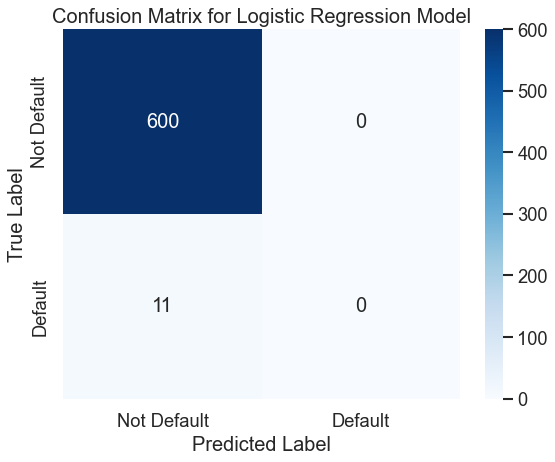

False Positive Rate (FPR): 0.000
Recall: 0.000
Precision: 0.000
F1 Score:  nan


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 预测测试集结果
y_pred = logfit.predict(X_test_encoded)

# 生成混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]
#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision

if (FP+TP) != 0:
     Precision = (TP)/(FP+TP)
else:
     Precision = 0
# F1 Score
if (Precision + Recall) != 0:
    F1 = 2 * (Precision * Recall)/(Precision + Recall)
else:
    F1 = 'nan'

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: ', F1)

The confusion matrix displayed shows the performance of a logistic regression model on a loan default prediction task. Let's break down the matrix:

- **True Positives (TP):** These are cases where the model correctly predicts the positive class. In this context, it would mean the model correctly predicts a loan default. However, we see a count of 0 for TP, indicating the model did not correctly predict any defaults.

- **True Negatives (TN):** These are cases where the model correctly predicts the negative class. Here, it corresponds to 600 cases where the model correctly identified loans that did not default.

- **False Positives (FP):** This would be the situation where the model incorrectly predicts a default when the loan did not actually default. The model has 0 FPs, which means it never predicted a default incorrectly.

- **False Negatives (FN):** This number (11) represents the loans that actually defaulted, but the model predicted they would not. This is a critical error for a loan default prediction model as it fails to identify the risk.

Given the values in the confusion matrix, we can discuss the following metrics:

- **False Positive Rate (FPR):** This is the number of false positives divided by the total number of actual negatives. The model has an FPR of 0, indicating there were no false alarms for defaults.

- **Recall (Sensitivity):** This measures the proportion of actual positives that were correctly identified. With a recall of 0, the model failed to identify any of the actual defaults.

- **Precision:** Precision is the number of true positives divided by the number of true positives plus false positives. Here, it's not applicable (shown as NaN), since there are no true positive predictions; the model never predicts defaults.

- **F1 Score:** The F1 Score is the harmonic mean of precision and recall. Here, it's not applicable because both precision and recall are 0.

The model's inability to predict defaults (i.e., it never predicts the positive class) suggests that it might be biased towards predicting non-defaults. This kind of bias often arises from imbalanced datasets, where one class (in this case, non-defaults) significantly outnumbers the other. The model may simply predict the majority class for all cases, achieving high accuracy but poor recall and precision for the minority class.

To conclude, the dataset likely needs to be balanced to improve the model's performance in predicting defaults. Techniques such as resampling the minority class, using SMOTE (Synthetic Minority Over-sampling Technique), or adjusting class weights in the model could help in achieving a more balanced prediction and a better generalization of the model to unseen data.

因此我们选择使用`OverSampling`和`UnderSampling`来处理这一问题，并应用，svm，决策树模型，回归分析：

---

## 1. Resampling

We can change the distribution of the classes in our training data. As we discussed in the notes, there are two main approaches, called as,

- Down-sampling the majority class (Undersampling)
- Up-sampling the minority class (Oversampling)
 

### Under-Sampling

The Down-sampling (Undersampling) involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm. 


In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold #About randomized search over parameters
from scipy.stats.distributions import uniform, loguniform # About creating random C values for regularization

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train_encoded, y_train)

In [ ]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 X_test_encoded, y_test 是测试集的特征和标签
# 使用在RandomizedSearchCV中选出的最佳模型和参数在测试集上进行预测
best_model = us_log_rs.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# 评估模型的性能
print("Classification report:")
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 如果需要更详细的交叉验证结果分析，可以从RandomizedSearchCV对象中提取信息
cv_results = us_log_rs.cv_results_
print("Best parameters found: ", us_log_rs.best_params_)
print("Best recall in cross validation: ", max(cv_results['mean_test_recall']))
# 也可以绘制各项指标随参数变化的图表，用于深入分析


### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train_encoded, y_train)

In [ ]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 使用最佳估计器进行预测
best_model = os_log_rs.best_estimator_
y_pred = best_model.predict(X_test_encoded)  # 假设你已经有一个变量X_test_encoded是处理过的测试特征数据
y_proba = best_model.predict_proba(X_test_encoded)[:, 1]  # 取决于模型是否有predict_proba方法

# 混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)  # 假设你已经有一个变量y_test是测试集的真实标签
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 分类报告
print(classification_report(y_test, y_pred))

# ROC曲线和AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


---

# Grid Search
- Before we start searching over hyperparameters, its worth noting that some of the folds may not have the same distribution of the classes. 
- This means we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual). 
- Therefore when doing our gridsearch/randomsearch, we should use a `StratifiedKFold` to ensure the distribution of classes in our folds reflects the distribution in the larger data.

In [28]:
# Example for n_splits = 5 below
# This is about just observing why StratifiedKFold is more suitable and we will use that function below 
# in the RandomizedSearchCV() function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)


fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    # Initialize an empty DataFrame to store counts for the current fold type
    fold_nos = pd.DataFrame()
    for j, (train_i, test_i) in enumerate(K.split(X_train_encoded, y_train)):
        # Compute value counts for the current fold and ensure it's a DataFrame with appropriate columns
        fold_no = pd.DataFrame(pd.Series(y_train.iloc[test_i]).value_counts()).T
        fold_no.index = ["Fold " + str(j)]  # Rename the index to reflect the fold number
        # Concatenate with the fold_nos DataFrame
        fold_nos = pd.concat([fold_nos, fold_no], axis=0)
    
    fold_nos.fillna(0, inplace=True)  # Fill missing values with 0 if any class was not present in a fold
    print(f"{fold_names[i]} counts per fold:\n", fold_nos)

KFold counts per fold:
 default   0.0  1.0
Fold 0   1086   13
Fold 1   1076   22
Fold 2   1071   27
Fold 3   1083   15
Fold 4   1073   25
StratifiedKFold counts per fold:
 default   0.0  1.0
Fold 0   1078   21
Fold 1   1078   20
Fold 2   1078   20
Fold 3   1078   20
Fold 4   1077   21


In [29]:
# This code snippet sets up and executes a randomized search for hyperparameter tuning 
# of a logistic regression model within a pipeline, using cross-validation. 

from scipy.stats.distributions import uniform, loguniform

# Pipeline Creation:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 1, random_state=42))])

# Generating a List of C Values: The values are chosen as powers of 2
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

# Randomized Search CV Setup:
log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, # each time with a different combination of parameters
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", # Refits the best model on the entire dataset using the accuracy metric 
                            random_state = 42,
                            return_train_score = True)

# Fitting the Randomized Search:
log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(C=1,
                                                                 random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1AEE1CD90>},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

1. Convert your `log_rs.cv_results_` into pandas data frame and sort the values in terms "mean_test_accuracy" in descending order by using `sort_values` function !!!

2. Look at the first 6 values in this sorted values and make comments on test accuracy

In [30]:
# About the summary of best 6 models 
# Convert your log_rs.cv_results_ into pandas data frame and sort the values in terms 
log_rs_df = pd.DataFrame(log_rs.cv_results_)

# "mean_test_accuracy" in descending order by using sort_values !!!
# Look at the first 6 values in this sorted values and make comments on test accuracy !!!
#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
58,0.058499,0.98238,0.00037,0.982335,0.001091
29,0.059499,0.98238,0.00037,0.982335,0.001091
32,0.077002,0.98238,0.00037,0.982153,0.000928
6,0.069911,0.98238,0.00037,0.982153,0.000928
42,0.050337,0.98238,0.00037,0.982153,0.000928


## 2.5. Logistic with Regularization <a id='SKV'></a>

- Note that regularized logistic regression is implemented using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers in scikits-learn. Note that regularization is applied by default as $L_2$.

**Warning The choice of the algorithm depends on the penalty chosen**. 
Supported penalties by solver:
- ‘lbfgs’ - [‘l2’, None]

- ‘liblinear’ - [‘l1’, ‘l2’]

- ‘newton-cg’ - [‘l2’, None]

- ‘newton-cholesky’ - [‘l2’, None]

- ‘sag’ - [‘l2’, None]

- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

- So, we can play with the parameters of `LogisticRegression` function, in terms of our needs

In [31]:
from scipy.stats.distributions import uniform, loguniform

log_pipe_l1 = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 1, random_state=42, penalty = 'l1', solver = 'liblinear'))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs_l1 = RandomizedSearchCV(log_pipe_l1, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs_l1.fit(X_train_encoded, y_train)

#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Pr

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
58,0.058499,0.98238,0.00037,0.982335,0.001091
29,0.059499,0.98238,0.00037,0.982335,0.001091
32,0.077002,0.98238,0.00037,0.982153,0.000928
6,0.069911,0.98238,0.00037,0.982153,0.000928
42,0.050337,0.98238,0.00037,0.982153,0.000928


---

##  Improving Models with Imbalances <a id='Imbal'></a>

__Optimising for Accuracy__ 

In [32]:
# This is the classification report based on the accuracy metric
from sklearn.metrics import classification_report

# For the model with l2 penalty already implemented above
print(pd.DataFrame(classification_report(y_test, 
                                   log_rs.predict(X_test_encoded), 
                                   labels = None, 
                                   target_names = list([0,1]), 
                                   sample_weight = None, 
                                   output_dict = True)).round(2))

                0     1  accuracy  macro avg  weighted avg
precision    0.98   0.0      0.98       0.49          0.96
recall       1.00   0.0      0.98       0.50          0.98
f1-score     0.99   0.0      0.98       0.50          0.97
support    600.00  11.0      0.98     611.00        611.00


c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Consider the following function for the new metric, `recall`, and then derive a similar classification report that you observed above

In [33]:
from sklearn.base import clone

# we refit the best accuracy model on all the training data
# so lets do that for the best other metric models, using the recall below
def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_" + metric, ascending = False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model

rec_model = manual_refit(log_pipe, X_train_encoded, y_train, log_rs, "recall")
print(pd.DataFrame(classification_report(y_test, 
                                   rec_model.predict(X_test_encoded), 
                                   labels = None, 
                                   target_names = list(), 
                                   sample_weight = None, 
                                   output_dict = True)).round(2))

                0     1  accuracy  macro avg  weighted avg
precision    0.98   0.0      0.98       0.49          0.96
recall       1.00   0.0      0.98       0.50          0.98
f1-score     0.99   0.0      0.98       0.50          0.97
support    600.00  11.0      0.98     611.00        611.00


c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\30252\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 1. Resampling

We can change the distribution of the classes in our training data. As we discussed in the notes, there are two main approaches, called as,

- Down-sampling the majority class (Undersampling)
- Up-sampling the minority class (Oversampling)
 

### Under-Sampling

The Down-sampling (Undersampling) involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm. 


In [34]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold #About randomized search over parameters
from scipy.stats.distributions import uniform, loguniform # About creating random C values for regularization

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1AED2ACA0>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [35]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
0,5.620905,0.735714,0.064909
24,17.404635,0.735714,0.064909
27,38.980718,0.735714,0.064909
28,115.223516,0.735714,0.064909
1,16547.046693,0.735714,0.064909


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84       600
         1.0       0.05      0.82      0.10        11

    accuracy                           0.73       611
   macro avg       0.52      0.77      0.47       611
weighted avg       0.98      0.73      0.83       611



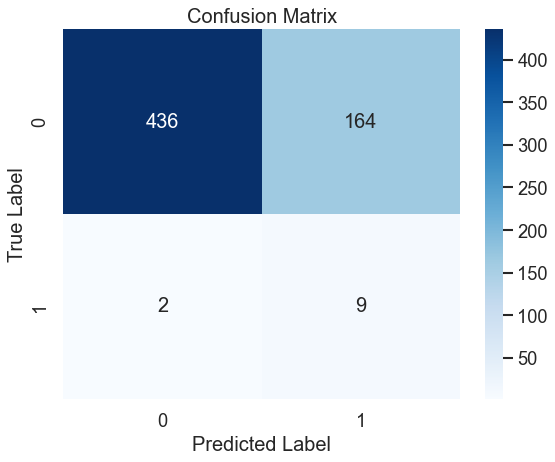

Best parameters found:  {'model__C': 5.620904786086303}
Best recall in cross validation:  0.7357142857142857


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 X_test_encoded, y_test 是测试集的特征和标签
# 使用在RandomizedSearchCV中选出的最佳模型和参数在测试集上进行预测
best_model = us_log_rs.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# 评估模型的性能
print("Classification report:")
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 如果需要更详细的交叉验证结果分析，可以从RandomizedSearchCV对象中提取信息
cv_results = us_log_rs.cv_results_
print("Best parameters found: ", us_log_rs.best_params_)
print("Best recall in cross validation: ", max(cv_results['mean_test_recall']))
# 也可以绘制各项指标随参数变化的图表，用于深入分析


### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples.

In [37]:
from imblearn.over_sampling import RandomOverSampler

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomOverSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1AF2D7E20>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [38]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
0,5.620905,0.725238,0.103297
1,16547.046693,0.725238,0.103297
32,0.077002,0.725238,0.103297
33,16132.816907,0.725238,0.103297
34,20348.582265,0.725238,0.103297


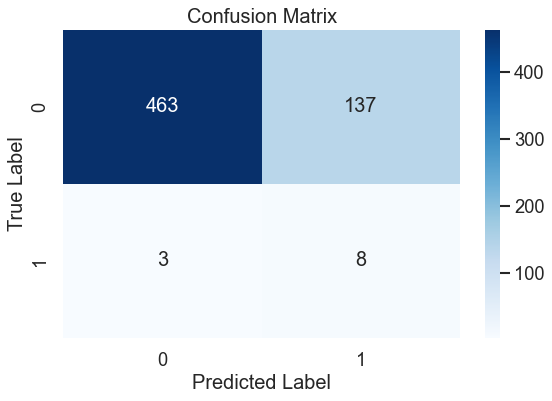

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87       600
         1.0       0.06      0.73      0.10        11

    accuracy                           0.77       611
   macro avg       0.52      0.75      0.49       611
weighted avg       0.98      0.77      0.85       611



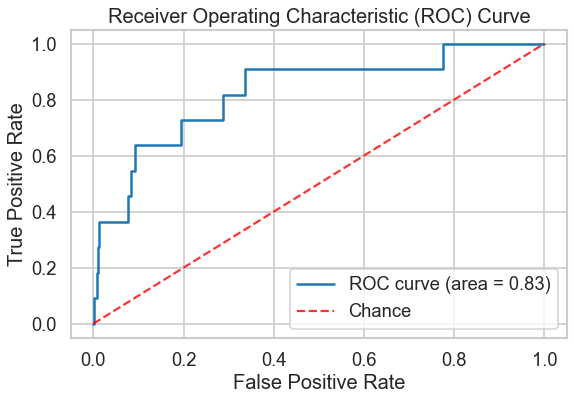

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 使用最佳估计器进行预测
best_model = os_log_rs.best_estimator_
y_pred = best_model.predict(X_test_encoded)  # 假设你已经有一个变量X_test_encoded是处理过的测试特征数据
y_proba = best_model.predict_proba(X_test_encoded)[:, 1]  # 取决于模型是否有predict_proba方法

# 混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)  # 假设你已经有一个变量y_test是测试集的真实标签
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 分类报告
print(classification_report(y_test, y_pred))

# ROC曲线和AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87       600
         1.0       0.06      0.73      0.10        11

    accuracy                           0.77       611
   macro avg       0.52      0.75      0.49       611
weighted avg       0.98      0.77      0.85       611



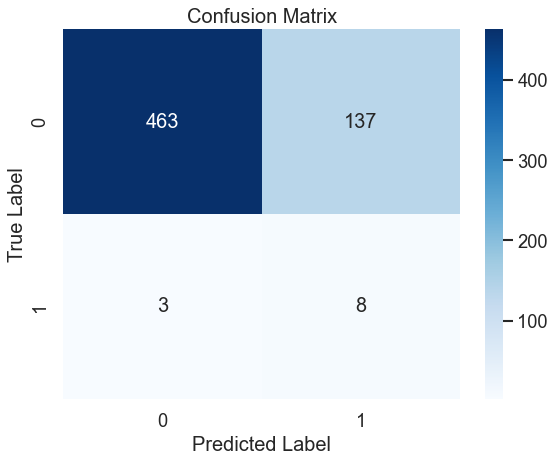

Best parameters found:  {'model__C': 5.620904786086303}
Best recall in cross validation:  0.7252380952380952


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 X_test_encoded, y_test 是测试集的特征和标签
# 使用在RandomizedSearchCV中选出的最佳模型和参数在测试集上进行预测
best_model = os_log_rs.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# 评估模型的性能
print("Classification report:")
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 如果需要更详细的交叉验证结果分析，可以从RandomizedSearchCV对象中提取信息
cv_results = os_log_rs.cv_results_
print("Best parameters found: ", os_log_rs.best_params_)
print("Best recall in cross validation: ", max(cv_results['mean_test_recall']))
# 也可以绘制各项指标随参数变化的图表，用于深入分析


---------

当数据集中的目标变量不平衡时，通过过采样较少样本类别的方法来平衡数据集的具体步骤如下：

### 步骤 1: 选择适合的过采样方法
可以选择简单的随机过采样或更复杂的方法，如SMOTE（Synthetic Minority Over-sampling Technique）。SMOTE通过在少数类样本之间插入新点来创建新的合成样本。

### 步骤 2: 分离少数类和多数类样本
在数据集中区分少数类样本和多数类样本，以便只对少数类样本进行过采样。

### 步骤 3: 进行过采样
执行过采样步骤来增加少数类样本，直到少数类和多数类的样本数量大致相同。

### 步骤 4: 合并样本
将过采样后的少数类样本与原来的多数类样本合并，形成一个新的平衡数据集。

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# 假设 X, y 是你的特征矩阵和目标变量
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 需要进行目标编码的列名列表
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# 将X_train和X_test合并回DataFrame形式，以便传递到自定义函数
train_data = X_train.join(y_train)
test_data = X_test

# 应用目标编码
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# 确保目标变量不在特征集中
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

# 输出训练集中各类别的样本数量
print('Original dataset shape %s' % Counter(y_train_encoded))

# 初始化SMOTE实例
smote = SMOTE(random_state=42)

# 过采样训练集
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded)

# 输出过采样后的数据集中各类别的样本数量
print('Resampled dataset shape %s' % Counter(y_train_resampled))

# 现在 X_resampled, y_resampled 可以用于训练模型


Original dataset shape Counter({0.0: 5387, 1.0: 104})
Resampled dataset shape Counter({0.0: 5387, 1.0: 5387})


In [42]:
logfit = LogisticRegression(random_state=42).fit(X_train_resampled, y_train_resampled)

print(logfit.score(X_test_encoded,y_test))

0.5908346972176759


In [43]:
# For class probabilities
class_prob = logfit.predict_proba(X_train_resampled)
print(class_prob)

[[0.60025714 0.39974286]
 [0.88760062 0.11239938]
 [0.87167279 0.12832721]
 ...
 [0.3869085  0.6130915 ]
 [0.21514392 0.78485608]
 [0.32338799 0.67661201]]


In [44]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features
# One can add more model in the dictionary
model_dict = {"log": LogisticRegression(random_state = 42, penalty = None)}

#print(model_dict[model_name]) 

for model_name in model_dict:
    logistic_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])


scores = tidy_scores(cross_validate(logistic_pipe, X_train_resampled, y_train_resampled, cv = 5, return_train_score = True))

# For all CV results
print(scores)

print(scores.loc[['mean', 'sd']])

      fit_time  score_time  val_score  train_score
fold                                              
0         0.04        0.00       0.93         0.97
1         0.04        0.00       0.96         0.96
2         0.04        0.00       0.97         0.96
3         0.04        0.01       0.96         0.96
4         0.04        0.00       0.97         0.96
mean      0.04        0.00       0.96         0.96
sd        0.00        0.00       0.01         0.00
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.04         0.0       0.96         0.96
sd        0.00         0.0       0.01         0.00


In [45]:
from sklearn.metrics import confusion_matrix

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, penalty = None))])

log_pipe.fit(X_train_resampled, y_train_resampled)

# use the classifier to predict the validation set    
# predictions = log_pipe.predict(X_val)
predictions = log_pipe.predict(X_test_encoded)
print(predictions)

# get the confusion matrix as a numpy array
#confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

# Just a direct output for the confusion matrix  
confmat

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

array([[589,  13],
       [  9,   0]], dtype=int64)

C:\Users\30252\AppData\Local\Temp\ipykernel_20476\2850195433.py:19: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2 * (Precision * Recall)/(Precision + Recall)


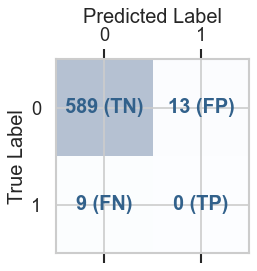

False Positive Rate (FPR): 0.022
Recall: 0.000
Precision: 0.000
F1 Score: nan


In [46]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]
#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, [0,1], "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

In [47]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline  # combining classifier steps

# One can add more model in the dictionary
logistic_CV = LogisticRegressionCV(cv = 5, random_state=42,  penalty='l2', Cs=10)

#print(model_dict[model_name]) 
logistic_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_dict[model_name])])

logistic_pipe_fit = logistic_pipe.fit(X_train_resampled, y_train_resampled)

logistic_pipe_fit.score(X_train_resampled, y_train_resampled)

# By default it uses Cs=10 but we can play around this

0.9603675515129014

In [48]:
# One can add more model in the dictionary
model_dict = {"log": LogisticRegression(random_state = 42, penalty = "l2")}

#print(model_dict[model_name]) 

for model_name in model_dict:
    logistic_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])


scores = tidy_scores(cross_validate(logistic_pipe, X_train_resampled, y_train_resampled, cv = 5, return_train_score = True))

print(scores)
# For all CV results
print(scores.loc[['mean', 'sd']])

      fit_time  score_time  val_score  train_score
fold                                              
0         0.05        0.00       0.93         0.97
1         0.04        0.00       0.96         0.96
2         0.07        0.00       0.97         0.96
3         0.05        0.00       0.96         0.96
4         0.05        0.01       0.97         0.96
mean      0.05        0.00       0.96         0.96
sd        0.01        0.00       0.01         0.00
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.05         0.0       0.96         0.96
sd        0.01         0.0       0.01         0.00


In [49]:
# Example for n_splits = 5 below
# This is about just observing why StratifiedKFold is more suitable and we will use that function below 
# in the RandomizedSearchCV() function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)


fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    # Initialize an empty DataFrame to store counts for the current fold type
    fold_nos = pd.DataFrame()
    for j, (train_i, test_i) in enumerate(K.split(X_train_resampled, y_train_resampled)):
        # Compute value counts for the current fold and ensure it's a DataFrame with appropriate columns
        fold_no = pd.DataFrame(pd.Series(y_train_resampled[test_i]).value_counts()).T
        fold_no.index = ["Fold " + str(j)]  # Rename the index to reflect the fold number
        # Concatenate with the fold_nos DataFrame
        fold_nos = pd.concat([fold_nos, fold_no], axis=0)
    
    fold_nos.fillna(0, inplace=True)  # Fill missing values with 0 if any class was not present in a fold
    print(f"{fold_names[i]} counts per fold:\n", fold_nos)

KFold counts per fold:
 default     0.0   1.0
Fold 0   2115.0    40
Fold 1   2118.0    37
Fold 2   1154.0  1001
Fold 3      0.0  2155
Fold 4      0.0  2154
StratifiedKFold counts per fold:
 default   0.0   1.0
Fold 0   1078  1077
Fold 1   1078  1077
Fold 2   1077  1078
Fold 3   1077  1078
Fold 4   1077  1077


In [50]:
# This code snippet sets up and executes a randomized search for hyperparameter tuning 
# of a logistic regression model within a pipeline, using cross-validation. 

from scipy.stats.distributions import uniform, loguniform

# Pipeline Creation:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 1, max_iter = 1000, random_state=42))])

# Generating a List of C Values: The values are chosen as powers of 2
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

# Randomized Search CV Setup:
log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 100, # each time with a different combination of parameters
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", # Refits the best model on the entire dataset using the accuracy metric 
                            random_state = 42,
                            return_train_score = True)

# Fitting the Randomized Search:
log_rs.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(C=1,
                                                                 max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=100,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B1B50507C0>},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [51]:
# About the summary of best 6 models 
# Convert your log_rs.cv_results_ into pandas data frame and sort the values in terms 
log_rs_df = pd.DataFrame(log_rs.cv_results_)

# "mean_test_accuracy" in descending order by using sort_values !!!
# Look at the first 6 values in this sorted values and make comments on test accuracy !!!
#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
44,1.129434,0.960600,0.003753,0.958884,0.014275
64,1.535481,0.960623,0.003803,0.958883,0.014275
0,5.620905,0.960739,0.003802,0.958791,0.014487
16,2.121147,0.960739,0.003859,0.958791,0.014454
61,1.344417,0.960646,0.003793,0.958791,0.014205


In [52]:
from scipy.stats.distributions import uniform, loguniform

log_pipe_l1 = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = 1, random_state=42, penalty = 'l1', solver = 'liblinear'))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs_l1 = RandomizedSearchCV(log_pipe_l1, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs_l1.fit(X_train_resampled, y_train_resampled)

#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
44,1.129434,0.960600,0.003753,0.958884,0.014275
64,1.535481,0.960623,0.003803,0.958883,0.014275
0,5.620905,0.960739,0.003802,0.958791,0.014487
16,2.121147,0.960739,0.003859,0.958791,0.014454
61,1.344417,0.960646,0.003793,0.958791,0.014205


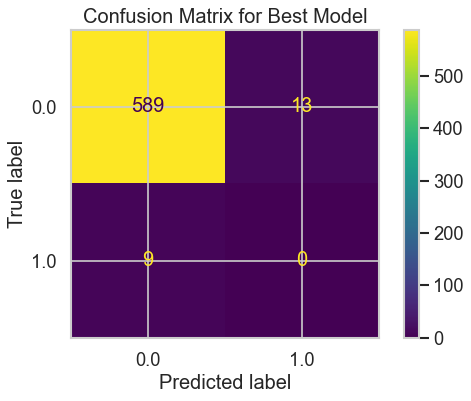

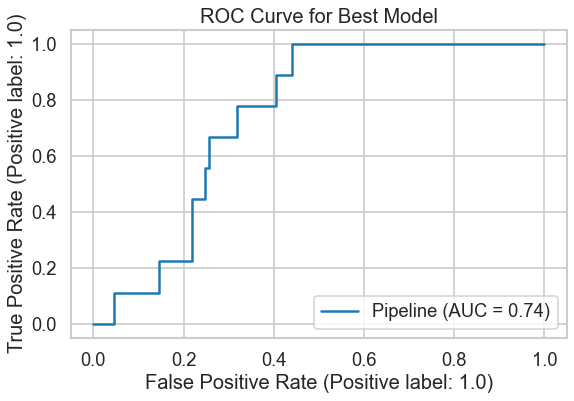

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 最佳模型的可视化混淆矩阵
best_model_l1 = log_rs_l1.best_estimator_
ConfusionMatrixDisplay.from_estimator(best_model_l1, X_test_encoded, y_test)
plt.title('Confusion Matrix for Best Model')
plt.show()

# 绘制ROC曲线
RocCurveDisplay.from_estimator(best_model_l1, X_test_encoded, y_test)
plt.title('ROC Curve for Best Model')
plt.show()


---

类似地，我们使用之前的简单得logisticregression进行机器学习，并评估重新生成数据集模型性能

In [54]:
logfit = LogisticRegression(random_state=42).fit(X_train_resampled, y_train_resampled)

print(logfit.score(X_test_encoded,y_test))

0.5908346972176759


In [55]:
from sklearn.metrics import confusion_matrix

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, penalty = None))])

log_pipe.fit(X_train_resampled, y_train_resampled)

# use the classifier to predict the validation set    
# predictions = log_pipe.predict(X_val)
predictions = log_pipe.predict(X_test_encoded)
print(predictions)

# get the confusion matrix as a numpy array
#confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

# Just a direct output for the confusion matrix  
confmat

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

array([[589,  13],
       [  9,   0]], dtype=int64)

C:\Users\30252\AppData\Local\Temp\ipykernel_20476\2850195433.py:19: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2 * (Precision * Recall)/(Precision + Recall)


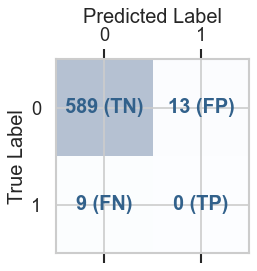

False Positive Rate (FPR): 0.022
Recall: 0.000
Precision: 0.000
F1 Score: nan


In [56]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]
#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, [0,1], "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)